# Kaggle Competition: Corporate Bankruptcy

This notebook contains the main logic I used for creating a ML model for this [Kaggle Competition](https://www.kaggle.com/competitions/prediccion-de-bancarrota-empresarial).

Some clarifications about this competition:
* It was a private competition between students in a 'Deep Learning' postgraduate university course.
* Only neural networks models were allowed to compete in the model.
* The dataset consisted of 2000 training data observations and 500 observations for test. Each observation corresponds to some key financial indicators of companies in the Shanghai Stock Exchange from 1999 to 2009. The objective was to predict the `Banrkruptcy` field, which is 1 if the company went Bakrupt, and 0 otherwise.


Even though I tried several different models and approaches, this notebook contains my best attempt, which managed to score me and my team second place overall out of 31 teams.

-----------
## 1. Data Processing

For this part, I must clarify I used other notebooks for exploring and processing the data in more detail, which in here I simply load.

Some takeaways from my reasoning in this part:
* Dropped a column that only had 1 distinct value in the training dataset, providing no predictive value.
* Some of the columns had high Pearson correlations between themselves, but neural networks are robust enough to 'learn' to ignore non-useful variables during their training process.
* I experimented reducing the number of features on the dataset with PCA while keeping 99% of the original variance (reducing the total features from 62 to 47), but this resulted in lesser predictive performance.

In [1]:
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split

# load files to Google Colab
files.upload()

df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv


In [2]:
# save test ids
test_ids = df_test['ID']

# drop unnecessary columns and arrange data
columns = ['ID', 'Net.Income.Flag']
y_training = df_train["Bankruptcy"]
x_training = df_train.drop(columns=columns)
x_training = x_training.drop(columns=['Bankruptcy'])
X_test = df_test.drop(columns=columns)

In the best implementation, I decided to use cross validation instead of a regular train-test split, in order to  select the most 'consistent' models that could translate to the test dataset.

In [3]:
from sklearn.preprocessing import StandardScaler

# scale data
scaler = StandardScaler()
x_training = scaler.fit_transform(x_training)
X_test = scaler.transform(X_test)

-------------------
## 2. Model Training and Selection

For the actual training of the model, seeing as this is a binary classification problem, binary crossentropy was selected as the model's loss function and AUC was selected as the metric to optimize.

* Adam was chosen as the optimizer, as it proved to give the best preliminar results in a previous study where several other options were also considered, including SGD, RMSprop, AdamW, Adadelta, Nadam, Ftrl, Lamb, RMSprop, Lion.

* A structure of 2 hidden layers with 400 and 200 hidden units respectively was used, as in previous attempts it had given fairly good results.
* Keras was chosen as the neural networks framework for the implementation, due to its easy of use and intuitive syntax.

* Finally, `optuna` was the library of choice for conducting the optimization study, as it provides the best compromise between GridSearch, which is very expensive computationally, and regular RandomSearch, which isn't as efficient. You're welcome to check out their documentation in [this link](https://optuna.org/).



In [ ]:
#!pip install optuna

In [4]:
# utils
import numpy as np

# keras
import tensorflow
from tensorflow import keras
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import (
    Input, Dense, Dropout
)
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay

# metrics
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.model_selection import StratifiedKFold

from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

# optimization
import optuna

In [ ]:
def objective(trial):
  '''
  Define the parameters for the first Optuna optimization study, selecting from the
  following hyperparameters:
    learning_rate_scheduler (with learning rate decay)
     : https://keras.io/api/callbacks/learning_rate_scheduler/
    Adam parameters: https://keras.io/api/optimizers/adam/
    Dropout for the two layers
    Activation function for the two hidden layers
     : https://keras.io/api/layers/activations/
    L1 and L2 regularization parameters
      https://keras.io/api/layers/regularizers/

  Params
  ----------
    trial: optuna.trial.Trial


  Returns
  ----------
    auc: float
      Average AUC of the model, for each of the k folds defined.
  '''
# part 1: define the possible hyperparameter space

  # lr scheduler
  initial_lr = trial.suggest_float("initial_lr", 1e-5, 5e-2, log=True)
  decay_steps = trial.suggest_int("decay_steps", 100, 10000)
  decay_rate = trial.suggest_float("decay_rate", 1e-4, 0.999, log=True)
  staircase = trial.suggest_categorical("staircase", [True, False])

  # adam
  beta_1 = trial.suggest_float("beta_1", 0.01, 0.999, log=True)
  beta_2 = trial.suggest_float("beta_2", 0.01, 0.99999, log=True)
  amsgrad = trial.suggest_categorical("amsgrad", [True, False])
  use_ema = trial.suggest_categorical("use_ema", [True, False])
  ema_momentum = trial.suggest_float("ema_momentum", 0.01, 0.99, log=True)
  weight_decay = trial.suggest_float("weight_decay", 1e-8, 1e-3, log=True)

  # L1 & L2 coefficients
  l1 = trial.suggest_float("l1", 1e-8, 4e-2, log=True)
  l2 = trial.suggest_float("l2", 1e-8, 4e-2, log=True)
  regularizer = regularizers.L1L2(l1=l1, l2=l2)

  # dropout
  dropout_1 = trial.suggest_float("dropout_1", 0.0, 0.5)
  dropout_2 = trial.suggest_float("dropout_2", 0.0, 0.5)

  # activation functions
  activation_1 = trial.suggest_categorical(
      "activation_1", ["relu", "tanh", "elu", "selu"]
  )
  activation_2 = trial.suggest_categorical(
      "activation_2", ["relu", "tanh", "elu", "selu"]
  )

# part 2: train and validate using cv, 3 splits
  kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
  val_auc_scores = []
  for train_idx, val_idx in kfold.split(x_training, y_training):
      # train - test split
      X_train_fold, X_val_fold = x_training[train_idx], x_training[val_idx]
      y_train_fold, y_val_fold = y_training[train_idx], y_training[val_idx]

      # build model
      model = keras.Sequential()
      model.add(keras.Input(shape=(X_train_fold.shape[1],)))
      model.add(Dense(400, activation=activation_1, kernel_regularizer=regularizer))  ## oculta 1
      model.add(Dropout(dropout_1))
      model.add(Dense(200, activation=activation_2, kernel_regularizer=regularizer))  ## oculta 2
      model.add(Dropout(dropout_2))
      model.add(Dense(1, activation="sigmoid"))

      # build optimizer
      lr_schedule = ExponentialDecay(
      initial_learning_rate=initial_lr,
      decay_steps= decay_steps,
      decay_rate=decay_rate,
      staircase=staircase
      )
      opt = Adam(
          learning_rate=lr_schedule,
          beta_1=beta_1,
          beta_2=beta_2,
          amsgrad=amsgrad,
          use_ema=use_ema,
          ema_momentum=ema_momentum,
          weight_decay=weight_decay,
      )

      # compile and train
      model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["AUC"])
      model.fit(
          X_train_fold, y_train_fold,
          validation_data=(X_val_fold, y_val_fold),
          epochs=25,
          batch_size=64,
          callbacks=[EarlyStopping(monitor="val_AUC", patience=5, mode="max", restore_best_weights=True)],
          verbose=0
      )
      # evaluate the fold and save metrics
      y_val_pred = model.predict(X_val_fold, verbose=0).ravel()
      try:
          auc = roc_auc_score(y_val_fold, y_val_pred)
      except ValueError:
          auc = 0.0
      val_auc_scores.append(auc)

  return np.mean(val_auc_scores)  # return the mean of all the k-fold AUCs

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

[I 2025-04-26 13:00:01,525] A new study created in memory with name: no-name-9a240080-4c5b-42e2-945a-c74b695e45b7
[I 2025-04-26 13:00:30,651] Trial 0 finished with value: 0.8210882483496665 and parameters: {'initial_lr': 0.0001834359051832191, 'decay_steps': 7055, 'decay_rate': 0.5993325815291857, 'staircase': False, 'beta_1': 0.27289078157513463, 'beta_2': 0.06752576773922461, 'amsgrad': False, 'use_ema': False, 'ema_momentum': 0.04057983957229193, 'weight_decay': 2.5476610743811413e-08, 'l1': 1.8054726664469408e-07, 'l2': 1.4836177642802724e-08, 'dropout_1': 0.10283557942367766, 'dropout_2': 0.44530756684058176, 'activation_1': 'elu', 'activation_2': 'selu'}. Best is trial 0 with value: 0.8210882483496665.
[I 2025-04-26 13:01:01,303] Trial 1 finished with value: 0.8597970068291731 and parameters: {'initial_lr': 0.00012781802278480142, 'decay_steps': 7202, 'decay_rate': 0.004422658218544969, 'staircase': False, 'beta_1': 0.184624210609505, 'beta_2': 0.44991707936952197, 'amsgrad': Fal

Now, we can analyze the results for this first study.

In [ ]:
optuna.visualization.plot_slice(study, params=[
    "initial_lr", "decay_steps", "decay_rate", "staircase",
    "beta_1", "beta_2", "amsgrad", "use_ema", "ema_momentum", "weight_decay",
    "l1", "l2", "dropout_1", "dropout_2", "activation_1", "activation_2"
    ]
)

From the observed results, we make the following decisions to reduce the next hyperparameter space:
* activation 1 = `['elu', 'selu']`
* activation 2 = `['tanh', 'selu']`
* amsgrad = `False`
* beta_1 between 0.2 and 1
* beta_2 between 0 and 0.1
* decay_rate < 1e-3
* decay steps > 4k
* no conclusion about dropout_1 and dropout_2
* ema_momentum > 0.1 with use_ema
* initial_lr between 1e-4 and 1e-2
* l1 between 1e-6 y 1e-2
* no conclusión about l2
* weight_decay no conclusion

In [ ]:
top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:5]
for i, trial in enumerate(top_trials, 1):
    print(f"\nTrial #{i}:")
    print(f"  AUC: {trial.value:.4f}")
    print(f"  Params: {trial.params}")


Trial #1:
  AUC: 0.9189
  Params: {'initial_lr': 0.001038090017092632, 'decay_steps': 7483, 'decay_rate': 0.00010053698103892269, 'staircase': False, 'beta_1': 0.2908726074245822, 'beta_2': 0.01904844431595933, 'amsgrad': False, 'use_ema': False, 'ema_momentum': 0.18142595977983955, 'weight_decay': 1.659629836518011e-05, 'l1': 0.0006242706472350695, 'l2': 2.7055248619690093e-05, 'dropout_1': 0.06293635516119828, 'dropout_2': 0.43044405059818297, 'activation_1': 'elu', 'activation_2': 'selu'}

Trial #2:
  AUC: 0.9182
  Params: {'initial_lr': 0.0009759916685758293, 'decay_steps': 7652, 'decay_rate': 0.0003507320378346748, 'staircase': False, 'beta_1': 0.4535316941845887, 'beta_2': 0.017600889853318796, 'amsgrad': False, 'use_ema': True, 'ema_momentum': 0.12140375964346785, 'weight_decay': 3.346376110726287e-06, 'l1': 0.00042532852448373427, 'l2': 1.7312659094770114e-05, 'dropout_1': 0.20345780713574532, 'dropout_2': 0.3930569580011441, 'activation_1': 'elu', 'activation_2': 'tanh'}

Tri

We now proceed to defining a second, more reduced hyperparameter study:

In [ ]:
def objective_2(trial):
  '''
  Define the parameters for the first Optuna optimization study, selecting from the
  following hyperparameters:
    learning_rate_scheduler
      : https://keras.io/api/callbacks/learning_rate_scheduler/
    Adam : https://keras.io/api/optimizers/adam/
    Dropout
    Activation function: https://keras.io/api/layers/activations/
    L1 & L2 regularization
    batch_size

  Params
  ----------
  * trial: optuna.trial.Trial

  Returns
  ----------
  * auc: float
    Average AUC of the model, for each of the k folds defined.
  '''
# part 1: define hyperparameter space

  # optimizer
  initial_lr = trial.suggest_float("initial_lr", 1e-4, 1e-2, log=True)
  decay_steps = trial.suggest_int("decay_steps", 4000, 10000)
  decay_rate = trial.suggest_float("decay_rate", 1e-6, 1e-3, log=True)
  staircase = trial.suggest_categorical("staircase", [True, False])

  beta_1 = trial.suggest_float("beta_1", 0.2, 0.999, log=True)
  beta_2 = trial.suggest_float("beta_2", 0, 0.1)
  use_ema = trial.suggest_categorical("use_ema", [True, False])
  ema_momentum = trial.suggest_float("ema_momentum", 0.1, 0.99, log=True)
  epsilon = trial.suggest_float("epsilon", 1e-8, 1e-4, log=True)


  # regularization
  l1 = trial.suggest_float("l1", 1e-6, 1e-2, log=True)
  l2 = trial.suggest_float("l2", 1e-10, 1e-2, log=True)
  regularizer = regularizers.L1L2(l1=l1, l2=l2)

  # dropout
  dropout_1 = trial.suggest_float("dropout_1", 0.0, 0.5)
  dropout_2 = trial.suggest_float("dropout_2", 0.0, 0.5)

  # act funcs
  activation_1 = trial.suggest_categorical("activation_1", ["elu", "selu"])
  activation_2 = trial.suggest_categorical("activation_2", ["tanh", "selu"])

  # batch size
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256])

# part 2: train and evaluate using CV
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  val_auc_scores = []
  for train_idx, val_idx in kfold.split(x_training, y_training):
      # train - test split
      X_train_fold, X_val_fold = x_training[train_idx], x_training[val_idx]
      y_train_fold, y_val_fold = y_training[train_idx], y_training[val_idx]

      # build model
      model = keras.Sequential()
      model.add(keras.Input(shape=(X_train_fold.shape[1],)))
      model.add(Dense(400, activation=activation_1, kernel_regularizer=regularizer))  ## oculta 1
      model.add(Dropout(dropout_1))
      model.add(Dense(200, activation=activation_2, kernel_regularizer=regularizer))  ## oculta 2
      model.add(Dropout(dropout_2))
      model.add(Dense(1, activation="sigmoid"))

      # build optimizer
      lr_schedule = ExponentialDecay(
      initial_learning_rate=initial_lr,
      decay_steps= decay_steps,
      decay_rate=decay_rate,
      staircase=staircase
      )
      opt = Adam(
          learning_rate=lr_schedule,
          beta_1=beta_1,
          beta_2=beta_2,
          amsgrad=False,
          use_ema=use_ema,
          ema_momentum=ema_momentum,
          epsilon=epsilon
      )

      # compile and train model
      model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["AUC"])
      model.fit(
          X_train_fold, y_train_fold,
          validation_data=(X_val_fold, y_val_fold),
          epochs=20,
          batch_size=batch_size,
          callbacks=[EarlyStopping(monitor="val_AUC", patience=5, mode="max", restore_best_weights=True)],
          verbose=0
      )
      # evaluation
      y_val_pred = model.predict(X_val_fold, verbose=0).ravel()
      try:
          auc = roc_auc_score(y_val_fold, y_val_pred)
      except ValueError:
          auc = 0.0
      val_auc_scores.append(auc)

  return np.mean(val_auc_scores)

study_2 = optuna.create_study(direction="maximize")
study_2.optimize(objective_2, n_trials=80)

[I 2025-04-26 16:22:24,671] A new study created in memory with name: no-name-71458a79-a597-4cc3-bd0d-7c38e9c6b1cd
[I 2025-04-26 16:23:34,266] Trial 0 finished with value: 0.8882910726856525 and parameters: {'initial_lr': 0.0009343478893557453, 'decay_steps': 6864, 'decay_rate': 0.0003620116781424914, 'staircase': False, 'beta_1': 0.2053726028267243, 'beta_2': 0.07663144873229867, 'use_ema': False, 'ema_momentum': 0.4575914536164636, 'epsilon': 1.8057101155117923e-05, 'l1': 5.5157773409925635e-05, 'l2': 0.0022544336395127055, 'dropout_1': 0.3957256046376545, 'dropout_2': 0.12245077099976337, 'activation_1': 'elu', 'activation_2': 'selu', 'batch_size': 16}. Best is trial 0 with value: 0.8882910726856525.
[I 2025-04-26 16:24:14,226] Trial 1 finished with value: 0.9002336652584113 and parameters: {'initial_lr': 0.0003490245258284037, 'decay_steps': 8327, 'decay_rate': 0.00013757371685450034, 'staircase': True, 'beta_1': 0.6160190276197686, 'beta_2': 0.07045867656277603, 'use_ema': False, '

We now check the effect of each hyperparameter on the results:

In [ ]:
optuna.visualization.plot_slice(study_2, params=[
    "initial_lr", "decay_steps", "decay_rate", "staircase",
    "beta_1", "beta_2", "use_ema", "ema_momentum", "epsilon",
    "l1", "l2", "dropout_1", "dropout_2", "activation_1", "activation_2", "batch_size"
    ]
)

We take the following conclusions:
* there's no benefit from L2 reg, Dropout in the first layer, nor calibrating the epsilon parameter within the optimizer
* `activation_1 = 'elu'`
* `activation_2 = 'selu'`
* `batch size >= 256`
* decay rate < 1e-5
* ema momentum < 0.2, use_ema = True
* initial_lr between 1e-3 and 1e-2
* l1 between 1e-4 and 1e-2
* `staircase = False`

In [ ]:
top_trials = sorted(study_2.trials, key=lambda t: t.value, reverse=True)[:5]
for i, trial in enumerate(top_trials, 1):
    print(f"\nTrial #{i}:")
    print(f"  AUC: {trial.value:.4f}")
    print(f"  Params: {trial.params}")


Trial #1:
  AUC: 0.9264
  Params: {'initial_lr': 0.0031082558361769257, 'decay_steps': 7060, 'decay_rate': 1.5291615683984966e-06, 'staircase': False, 'beta_1': 0.6342592223944361, 'beta_2': 0.007885379280907365, 'use_ema': True, 'ema_momentum': 0.1330806138430609, 'epsilon': 9.327362338353984e-07, 'l1': 0.00019702491862126655, 'l2': 5.334585885308617e-10, 'dropout_1': 0.0492019918532704, 'dropout_2': 0.27318626764616666, 'activation_1': 'elu', 'activation_2': 'selu', 'batch_size': 256}

Trial #2:
  AUC: 0.9214
  Params: {'initial_lr': 0.0033364862012138603, 'decay_steps': 6332, 'decay_rate': 2.0692173008075147e-06, 'staircase': False, 'beta_1': 0.5703489582526643, 'beta_2': 0.015852273792912194, 'use_ema': True, 'ema_momentum': 0.1240599611173263, 'epsilon': 1.3864136853372284e-05, 'l1': 0.0014745183205957767, 'l2': 1.0858535859965522e-10, 'dropout_1': 0.4654698187850549, 'dropout_2': 0.18481050284034856, 'activation_1': 'elu', 'activation_2': 'selu', 'batch_size': 256}

Trial #3:
  

For the final study, we first make sure we're getting results as reproducible as possible. However, this isn't 100% failproff, since the Dropout still happens randomly when training the model.

In [6]:
import random

seed = 50
np.random.seed(seed)
tensorflow.random.set_seed(seed)
random.seed(seed)

In [ ]:
def objective_3(trial):
  '''
 Define the parameters for the first Optuna optimization study, selecting from the
following hyperparameters:
    learning_rate_scheduler
    Adam
    Dropout (second layer)
    L1 regularization
    batch_size

  Params
  ----------
  * trial: optuna.trial.Trial

  Returns
  ----------
  * auc: float
    Average AUC of the model, for each of the k folds defined.
  '''
# part 1: definir the hyperparameter space

  # optimizer
  initial_lr = trial.suggest_float("initial_lr", 1e-3, 1e-2)
  decay_steps = trial.suggest_int("decay_steps", 4000, 10000)
  decay_rate = trial.suggest_float("decay_rate", 1e-7, 1e-5, log=True)

  beta_1 = trial.suggest_float("beta_1", 0.2, 0.999, log=True)
  beta_2 = trial.suggest_float("beta_2", 0, 0.1)
  ema_momentum = trial.suggest_float("ema_momentum", 0.001, 0.2, log=True)
  epsilon = trial.suggest_float("epsilon", 1e-8, 1e-4, log=True)

  # regularization
  regularizer = regularizers.L1L2(
      l1=trial.suggest_float("l1", 1e-4, 1e-2, log=True),
      l2=0
  )

  # dropout
  dropout_2 = trial.suggest_float("dropout_2", 0.0, 0.5)

  # batch size: set as mutiples of the training fold
  batch_size = trial.suggest_categorical("batch_size", [150, 300, 600, 900])

# part 2: train and test using 10-fold cv
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=69)
  val_auc_scores = []
  for train_idx, val_idx in kfold.split(x_training, y_training):
      # train - test
      X_train_fold, X_val_fold = x_training[train_idx], x_training[val_idx]
      y_train_fold, y_val_fold = y_training[train_idx], y_training[val_idx]

      # build model
      model = keras.Sequential()
      model.add(keras.Input(shape=(X_train_fold.shape[1],)))
      model.add(Dense(400, activation='elu', kernel_regularizer=regularizer))  ## oculta 1
      model.add(Dense(200, activation='selu', kernel_regularizer=regularizer))  ## oculta 2
      model.add(Dropout(dropout_2))
      model.add(Dense(1, activation="sigmoid"))

      # build optimizer
      lr_schedule = ExponentialDecay(
      initial_learning_rate=initial_lr,
      decay_steps= decay_steps,
      decay_rate=decay_rate,
      staircase=False
      )
      opt = Adam(
          learning_rate=lr_schedule,
          beta_1=beta_1,
          beta_2=beta_2,
          use_ema=True,
          ema_momentum=ema_momentum,
          epsilon=epsilon
      )

      # compile and train
      model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["AUC"])
      model.fit(
          X_train_fold, y_train_fold,
          validation_data=(X_val_fold, y_val_fold),
          epochs=20,
          batch_size=batch_size,
          callbacks=[EarlyStopping(monitor="val_AUC", patience=5, mode="max", restore_best_weights=True)],
          verbose=0
      )
      # evaluate fold
      y_val_pred = model.predict(X_val_fold, verbose=0).ravel()
      try:
          auc = roc_auc_score(y_val_fold, y_val_pred)
      except ValueError:
          auc = 0.0
      val_auc_scores.append(auc)

  return np.mean(val_auc_scores)

study_3 = optuna.create_study(direction="maximize")
study_3.optimize(objective_3, n_trials=30)

[I 2025-04-27 01:51:42,262] A new study created in memory with name: no-name-7dcdd21b-5a3f-4307-92e4-2c5b4cfe38af
[I 2025-04-27 01:52:35,192] Trial 0 finished with value: 0.7773169599802765 and parameters: {'initial_lr': 0.005319880771850862, 'decay_steps': 7607, 'decay_rate': 2.2021719280262346e-07, 'beta_1': 0.8263327154616105, 'beta_2': 0.006774846982951577, 'ema_momentum': 0.0192049005219096, 'epsilon': 1.7350428373361935e-07, 'l1': 0.006207755660537157, 'dropout_2': 0.4589566302570351, 'batch_size': 150}. Best is trial 0 with value: 0.7773169599802765.
[I 2025-04-27 01:53:32,422] Trial 1 finished with value: 0.8988506747300716 and parameters: {'initial_lr': 0.00953354719104721, 'decay_steps': 9382, 'decay_rate': 9.389876805199659e-07, 'beta_1': 0.3456695563930422, 'beta_2': 0.06497942367195837, 'ema_momentum': 0.07819843340254214, 'epsilon': 7.461968311963698e-07, 'l1': 0.00029144178959249255, 'dropout_2': 0.21854500756013584, 'batch_size': 600}. Best is trial 1 with value: 0.8988

We check for one last time the effect each hyperparameter has on model performance:

In [ ]:
optuna.visualization.plot_slice(study_3, params=[
    "initial_lr", "decay_steps", "decay_rate",
    "beta_1", "beta_2", "ema_momentum", "epsilon",
    "l1", "dropout_2", "batch_size"
    ]
)

At the end of this new study, we can observe it's much harder to extract clear insights on how to reduce even further the optimization space, which is a good sign we've extracted most of the performance possible from this methodology. There's little use of defining a following study.

In [ ]:
top_trials = sorted(study_3.trials, key=lambda t: t.value, reverse=True)[:5]
for i, trial in enumerate(top_trials, 1):
    print(f"\nTrial #{i}:")
    print(f"  AUC: {trial.value:.4f}")
    print(f"  Params: {trial.params}")


Trial #1:
  AUC: 0.9336
  Params: {'initial_lr': 0.00783135886112703, 'decay_steps': 4432, 'decay_rate': 1.2456639322381967e-06, 'beta_1': 0.28125392008591626, 'beta_2': 0.01277737948720659, 'ema_momentum': 0.014243486345339824, 'epsilon': 1.2330635045228765e-05, 'l1': 0.0013064948034654407, 'dropout_2': 0.3650658092229453, 'batch_size': 150}

Trial #2:
  AUC: 0.9336
  Params: {'initial_lr': 0.007695571833756127, 'decay_steps': 6956, 'decay_rate': 3.823471254098353e-07, 'beta_1': 0.20850483329769495, 'beta_2': 0.08071998153276558, 'ema_momentum': 0.007837185056156513, 'epsilon': 1.4167667355592839e-05, 'l1': 0.0012140752262092198, 'dropout_2': 0.12649906419279683, 'batch_size': 150}

Trial #3:
  AUC: 0.9309
  Params: {'initial_lr': 0.006111980498919992, 'decay_steps': 4078, 'decay_rate': 1.2203349101107824e-06, 'beta_1': 0.32605942626050943, 'beta_2': 0.03388807602681716, 'ema_momentum': 0.001826742752645186, 'epsilon': 1.1633086392144088e-05, 'l1': 0.0005479291862744917, 'dropout_2':

We can also osberve each study has helped us get a progressively better performance from the model, as evaluated by its AUC. We went from 0.9181 in trail 1 to 0.9264 in trial 2, to 0.9336 on trial 3.

--------------
## 3. Generate predictions

We now implement the best model found from all the previous iterations, so we can generate our predictions csv and post it on the competition.

On this instance, we use a 90-10 random split on the initial data. We don't use the entire dataset, as it's still important to monitor we don't overfit the data, which would ultimately affect prediction quality.

In [7]:
# split training dataset
X_train, X_val, y_train, y_val = train_test_split(x_training, y_training, test_size=0.1, random_state=seed)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

Now, we build the model plugging in the best parameters from the third study.

We define a checkpoint so that we save the model that gives us the best validation AUC through all of the training epochs, so we have the option of selecting a model checkpoint other than that at the end of all its training epochs.

In [13]:
regularizer = regularizers.L1L2(
    l1=0.0013064948034654407,
    l2=0
)
# build model
model = keras.Sequential()
model.add(keras.Input(shape=(x_training.shape[1],)))
model.add(Dense(400, activation='elu', kernel_regularizer=regularizer))  ## oculta 1
model.add(Dense(200, activation='selu', kernel_regularizer=regularizer))  ## oculta 2
model.add(Dropout(0.3650658092229453))
model.add(Dense(1, activation="sigmoid"))

# build optimizer
lr_schedule = ExponentialDecay(
initial_learning_rate=0.00783135886112703,
decay_steps=4432,
decay_rate=1.2456639322381967e-06,
staircase=False
)
opt = Adam(
    learning_rate=lr_schedule,
    beta_1=0.28125392008591626,
    beta_2=0.01277737948720659,
    use_ema=True,
    ema_momentum=0.014243486345339824,
    epsilon=1.2330635045228765e-05
)
# define callbacks
checkpoint = ModelCheckpoint(
  "best_model.keras",
  monitor="val_AUC",
  mode="max",
  save_best_only=True,
  save_weights_only=False,
  verbose=1
)

# compile and train model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["AUC"])
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=150,
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/20
 9/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.5242 - loss: 6.6877
Epoch 1: val_AUC improved from -inf to 0.55700, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - AUC: 0.5531 - loss: 6.0705 - val_AUC: 0.5570 - val_loss: 1.6042
Epoch 2/20
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.6686 - loss: 1.2252 
Epoch 2: val_AUC improved from 0.55700 to 0.96320, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.6882 - loss: 1.1210 - val_AUC: 0.9632 - val_loss: 0.5119
Epoch 3/20
 9/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8682 - loss: 0.5163 
Epoch 3: val_AUC improved from 0.96320 to 0.97439, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8674 - loss: 0.5050 - val_AUC: 0.9744 - val_loss: 0.4602
Epoch 4/20
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.8951 - loss: 0.4859 
Epoch 4: val_AUC did not improve from 0.97439
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.8843 - loss: 0.4809

Let's take a look at the evolution in the training and validation AUCs:

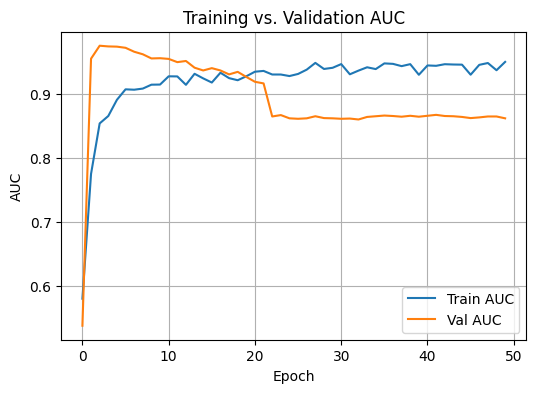

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(6, 4))

plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
#plt.xlim(0, 50)
plt.title('Training vs. Validation AUC')
plt.legend()
plt.grid(True)
plt.show()

After playing around a little with callbacks, total epochs and predictions for the competitions, I found the following:

* Selecting the model with the best AUC (around the fifth epoch) isn't a good idea, as somehow the model overfits unseen data over its training data. Basically, this validation perfomancr is too good to be true.

* After epoch 22 or so, we clearly see that the model starts to overfit its training data, at the expense of performance on the validation dataset.

* The epoch that actually gave the best results was epoch 18, which is very close to 20, the value we set fixed for all of the optimization studies. As we can see on the graph, in this point there's a balance between validation and testing performance and this is the goldilocks zone for our model. It also makes sense, since the optimization studies were unintentionally selecting for models that performed their best at around 20 epochs. To save this model you can simply re-train the model from the previous cell, while setting `epochs=18`.

Lastly, we load the model checkpoint of preference and generate a csv, ready for uploading to the Kaggle competition site.

In [14]:
# best_model = keras.models.load_model('best_model.keras', compile=False)
y_pred = model.predict(X_val)
print(f"AUC val best model: {round(roc_auc_score(y_val, y_pred), 6)}")
y_pred_train = model.predict(X_train)
print(f"AUC train best model: {round(roc_auc_score(y_train, y_pred_train), 6)}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
AUC val best model: 0.940115
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC train best model: 0.952727


In [ ]:
X_test.shape

(500, 62)

In [ ]:
import numpy as np

# generate the new predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1, 1)
ids = test_ids.to_numpy().reshape(-1, 1)
combined = np.hstack((ids, y_pred))

# convert to DataFrame and save
df = pd.DataFrame(combined, columns=["ID", "Bankruptcy"])
df["ID"] = df["ID"].astype(int)
df["Bankruptcy"] = df["Bankruptcy"]
df.to_csv("submission.csv", index=False)
files.download("submission.csv")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>